In [30]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from scipy.ndimage.interpolation import shift

%matplotlib inline

### MNIST

In [2]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
print(mnist['DESCR'])

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

In [4]:
X, y = mnist['data'], mnist['target']

In [5]:
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
some_digit = X.loc[0]
some_digit_image = some_digit.values.reshape(28, 28)

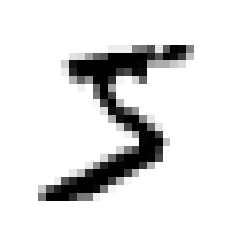

In [8]:
plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [9]:
y[0]

'5'

In [10]:
y = y.astype(np.uint8)

In [11]:
i = 60000
X_train, X_test, y_train, y_test = X[:i], X[i:], y[:i], y[i:]

### Training a binary classifier

In [20]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [22]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [23]:
sgd_clf.predict([some_digit])

array([ True])

### Measuring accuracy using cross-validation

In [26]:
skfolds = StratifiedKFold(n_splits=3)

In [34]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.loc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.loc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.95035
0.96035
0.9604


In [36]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [39]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [40]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [42]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [44]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [45]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

$$ \mathrm{precision} = \frac{TP}{TP + FP} $$

In [48]:
3530 / (3530 + 687)

0.8370879772350012

$$ \mathrm{recall} = \frac{TP}{TP + FN} $$

In [49]:
3530 / (3530 + 1891)

0.6511713705958311

### Precision and Recall

In [51]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [52]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

$$ F_{1} = \frac{2}{\frac{1}{\mathrm{precision}} + \frac{1}{\mathrm{recall}}} = 2 \times \frac{\mathrm{precision} \times \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}} = \frac{TP}{TP + \frac{FN + FP}{2}} $$

In [55]:
3530 / (3530 + ((1891 + 687) / 2))

0.7325171197343847

In [57]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

### Precision/recall trade-off

In [58]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [60]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [61]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [62]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [64]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

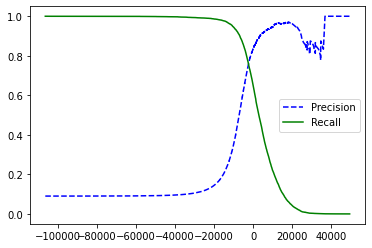

In [65]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

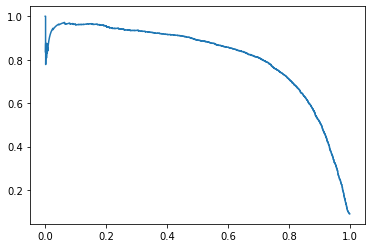

In [66]:
plt.plot(recalls, precisions)

In [67]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [70]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [71]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [72]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC curve

In [74]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

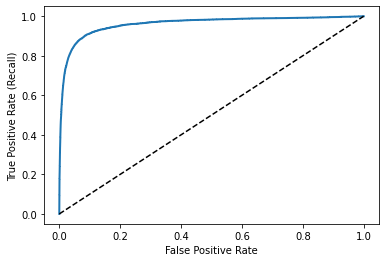

In [76]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    
plot_roc_curve(fpr, tpr)
plt.show()

In [79]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [81]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [82]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

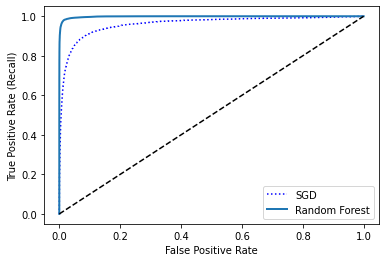

In [88]:
plt.plot(fpr, tpr, "b:", label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random Forest')
plt.legend(loc='lower right')
plt.show()

In [89]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

### Multiclass classification

In [91]:
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [92]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [93]:
np.argmax(some_digit_scores)

5

In [94]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [96]:
svm_clf.classes_[5]

5

In [99]:
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC())

In [100]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [101]:
len(ovr_clflf.estimators_)

10

In [102]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [103]:
sgd_clf.decision_function([some_digit])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [104]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [106]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, cv=3, scoring='accuracy')

/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: fit() missing 1 required positional argument: 'y'

  warnings.warn("Estimator fit failed. The score on this train-test"
/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 591, in _fit_and_score
    estimator.fit(X_train, **fit_params)
TypeError: fit() missing 1 required positional argument: 'y

array([nan, nan, nan])

### Error accuracy

In [107]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

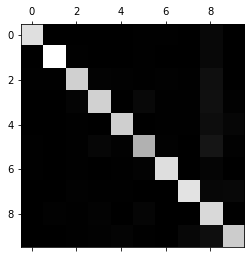

In [108]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [109]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

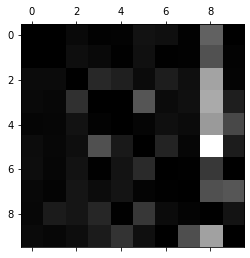

In [110]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [111]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [135]:
X_aa

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59961,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59964,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

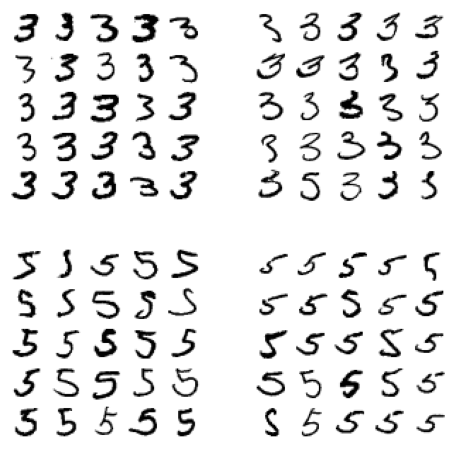

In [137]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25].values, images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25].values, images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25].values, images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25].values, images_per_row=5)
plt.show()

### Multilabel Classification

In [120]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

In [121]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [122]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [123]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

### Multioutput classification

In [124]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [125]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

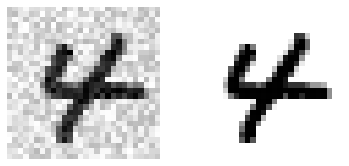

In [130]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod.iloc[some_index].values)
plt.subplot(122); plot_digit(y_test_mod.iloc[some_index].values)
# save_fig("noisy_digit_example_plot")
plt.show()

In [133]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

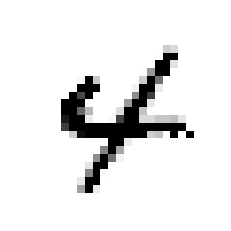

In [134]:
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index]])
plot_digit(clean_digit)

### Exercises

#### 1.

In [12]:
grid = {
    'n_neighbors': [3, 5, 7]
}

knn_clf = KNeighborsClassifier()

In [13]:
grid_search = GridSearchCV(knn_clf, grid, cv=3, scoring='accuracy')

In [14]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7]}, scoring='accuracy')

In [15]:
y_pred = grid_search.best_estimator_.predict(X_test)
n_correct = sum(y_pred == y_test)
print(n_correct / len(y_pred))

0.9705


#### 2.

In [56]:
def df_shift(s):
    
    def f(x):
        return shift(x.values.reshape(28, 28), s, cval=0).reshape(-1)
    
    
    df = X_train.apply(f, axis=1)
    
    return pd.DataFrame(df.to_frame(name='l')['l'].tolist(), columns=X_train.columns)

In [57]:
df_full = pd.concat([df_shift(s) for s in [[0, 1], [0, -1], [1, 0], [-1, 0]]])

In [62]:
X_train_full = pd.concat([X_train, df_full.round().abs()])

In [64]:
y_train_full = pd.concat([y_train, y_train, y_train, y_train, y_train])

In [63]:
best_clf = grid_search.best_estimator_

In [67]:
best_clf.fit(X_train_full, y_train_full)

KNeighborsClassifier(n_neighbors=3)

In [72]:
y_pred = best_clf.predict(X_test)
n_correct = sum(y_pred == y_test)
print(n_correct / len(y_pred))

0.9756
